# SAXS processing

J'essaye d'intégrer dans ce notebook chaque étape du traitement d'une manip SAXS sur D2AM.

## Préambule et définitions valables pour tout

### Quelques imports du départs

In [185]:
%pylab inline
from scipy import interpolate # je crois que ca ne sert que pour la fonction glassy
from scipy import ndimage # sert au moins pour le filtre médian utilisé pour faire le masque
from scipy.optimize import curve_fit # pour les fits
import fabio
import pyFAI
from pyFAI.distortion import Distortion
import glob
import os

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Intensité théorique diffusé par le carbone vitreux (glassy carbon)

Le carbone vitreux servira de référence à plusieurs niveaux et aide à "calibrer" et régler la manip. Il est indispensable d'en mesurer dans chaque configuration différente.

In [2]:
# fonction "théorique" du signal correctement normalisé du carbone vitreux 
# (servira pour faire un flat si possible, et pour trouver l'intensité absolue)
def glassyTheo(q):
	coefs=array([[0.15108,    -0.061981,    -0.056279 ,      6.0347], 
				[-0.15284,     0.048785,    -0.059504,       6.0194],
				[0.052117,    -0.063203,    -0.063026,       6.0056],
				[0.021452,     -0.02502,    -0.084571 ,      5.9872],
				[0.066288  , -0.0093093 ,   -0.092951  ,     5.9654],
				[-0.089808,     0.039221 ,   -0.085652  ,     5.9431],
				[0.19427 ,   -0.026516   , -0.082552    ,   5.9232],
				[-0.2687  ,    0.11566   , -0.060803    ,   5.9043],
				[-0.66041 ,   -0.080969  ,   -0.05234   ,    5.8925],
				[-0.86627 ,    -0.56419  ,   -0.20969   ,    5.8653],
				[-0.83792  ,     -1.198  ,   -0.63943   ,    5.7681],
				[-0.15168   ,    -1.811  ,    -1.3732   ,    5.5287],
				[0.68632    ,   -1.922   ,   -2.2835    ,    5.084],
				[2.1223     , -1.4199    ,  -3.0984     ,  4.4228],
				[0.66328    ,  0.13242   ,   -3.4123    ,   3.6138],
				[0.33124    ,  0.61752   ,   -3.2295    ,   2.7994],
				[-2.5861    ,  0.85973   ,   -2.8694    ,   2.0537],
				[1.4199    ,  -1.0309   ,   -2.9111    ,   1.3681],
				[0.4144  ,  0.0067539   ,   -3.1605    ,  0.61832]])
	coefs=transpose(coefs)
	breaks=array([-4.695,
      			-4.4506,
      			-4.2063,
      			-3.9621,
       			-3.718,
      			-3.474,
        		-3.23,
       			-2.986,
      			-2.7421,
      			-2.4982,
      			-2.2543,
      			-2.0105,
      			-1.7666,
      			-1.5228,
       			-1.279,
      			-1.0352,
     			-0.79144,
     			-0.54775,
     			-0.30415,
    			-0.060706])				
	glassyPoly=interpolate.PPoly(coefs,breaks)
	I=exp(glassyPoly(log(q)))
	return I

## Définitions et constantes *propres à la manip*

In [254]:
# Defintion du path de la manip
pathExp="/data/bm02/degeuser/02-01-863/"
os.chdir(pathExp+"analysis/testJupyter")

# Image du glassy carbon, du AgBh et du vide
glassyName=pathExp+"/raw/four/15Dec03D7_0506.edf.gz"
AgBhName=pathExp+"/raw/four/15Dec03D7_0505.edf.gz"
bdfName=pathExp+"raw/four/15Dec03D7_1311.edf.gz"

# Nom du fichier mask (pas encore créé)
maskName=pathExp+"analysis/testJupyter/mask.edf"

# ouverture du glassy et AgBh
glassy=fabio.open(glassyName)
AgBh=fabio.open(AgBhName)
bdf=fabio.open(bdfName)

## Définition du détecteur

In [4]:
# charge le détecteur
det = pyFAI.detector_factory("../d7_flat.h5") # pour le d7 (CdTe), fichier créé maison
#det = pyFAI.detector_factory("xpad_flat") # pour le D5, built-in dans pyFAI

print(det)

Xpad S540 flat detector from NeXus file: ../d7_flat.h5	 PixelSize= 1.300e-04, 1.300e-04 m


## Création du masque

Je fais un filtre médian (assez large) du glassy carbone, et je filtre tous les pixels dont l'intensité relative est supérieure à un certain seuil (ex: 30%). 

/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


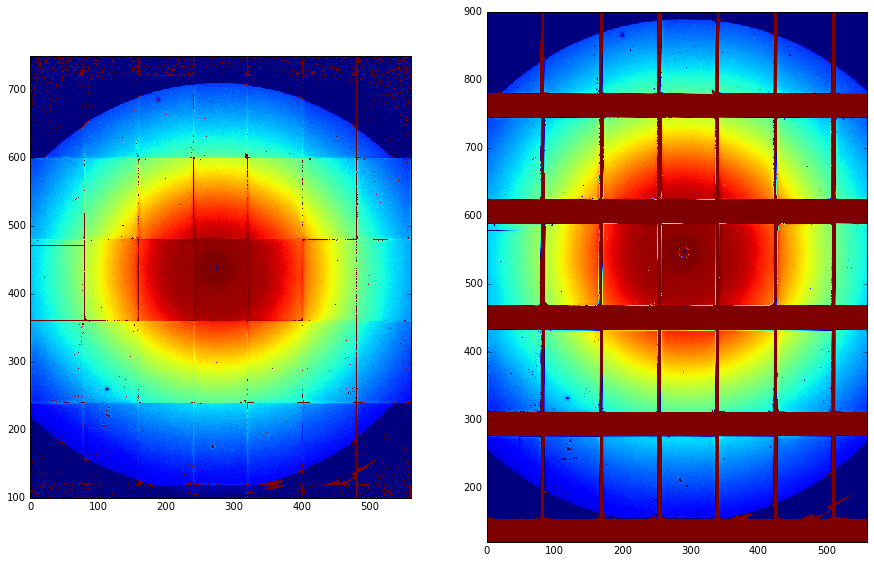

In [33]:
extMed=15 #extension en pixel du filtre médian
med_glassy=(ndimage.median_filter(glassy.data,extMed))
limFilt=0.3 # limite relative au dela de laquelle on considère qu'un pixel est "chaud" ou à la rue
mask=abs(glassy.data-med_glassy)/med_glassy>limFilt
det.mask=mask
dis = Distortion(det,resize=True)

dummy=10**5
figure(figsize=(15,15))
subplot(1,2,1)
view=where(mask,dummy,glassy.data)
imshow(log10(view), interpolation="nearest", origin="lower")
axis([0, 560, 100, 750])
#axis([0, 100, 450, 600])
clim([3, 5])
subplot(1,2,2)
view=dis.correct(where(mask,dummy,glassy.data),dummy=dummy)
imshow(log10(view), interpolation="nearest", origin="lower")
axis([0, 560, 120, 900])
#axis([0, 100, 450, 600])
clim([3, 5])

Ensuite je masque les bandes inter modules et inter chips (**à adapter en fonction du détecteur**).

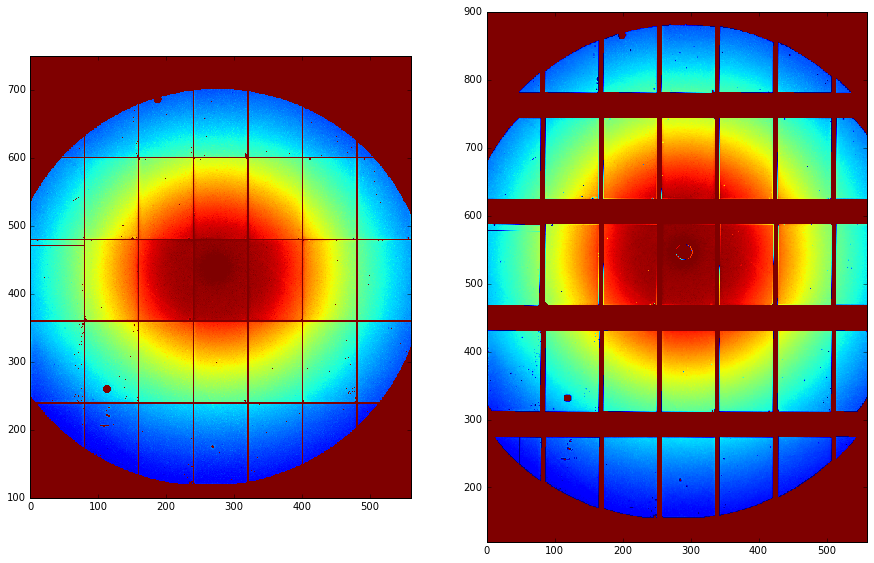

In [45]:
for mod in range(8):
	mask[mod*120,:]= True
	mask[mod*120+119,:]= True
	
for mod in range(7):
	mask[:,mod*80]= True
	mask[:,mod*80+79]= True
    
det.mask=mask
dis = Distortion(det,resize=True)

dummy=10**5
figure(figsize=(15,15))
subplot(1,2,1)
view=where(mask,dummy,glassy.data)
imshow(log10(view), interpolation="nearest", origin="lower")
axis([0, 560, 100, 750])
#axis([0, 100, 450, 600])
clim([3, 5])
subplot(1,2,2)
view=dis.correct(where(mask,dummy,glassy.data),dummy=dummy)
imshow(log10(view), interpolation="nearest", origin="lower")
axis([0, 560, 120, 900])
#axis([0, 100, 450, 600])
clim([3, 5])

Puis viennent les masques _géométriques_. Il s'agit principalement du masque (circulaire) du beam stop et du masque (ou plutot la ROI, l'inverse d'un masque) du tube. Le tube est également défini par un cercle, mais comme il se répartit sur plusieurs module, il peut etre nécessaire de le définir en plusieurs fois... **A adapter à chaque manip**

Pour cela je fais des tests sur les coordonnées (du type distance supérieure ou inférieure à un rayon donné). Ceci peut etre plus ou moins facile dans l'une ou l'autre des géométries (*brute* ou *corrigée*). C'est pourquoi je le fais plutot en *brute* pour le beam stop et en *corrigé* pour l'ombrage du tube.

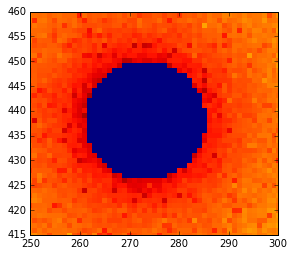

In [70]:
# coordonnées des pixels 
[Y,X]=mgrid[0:dis.shape_in[0],0:dis.shape_in[1]]
[Y0,X0]=mgrid[0:dis.shape_out[0],0:dis.shape_out[1]]

# Cercle sur le beamstop
Xc=273.2;
Yc=438;
R=12;
dist=sqrt((X-Xc)**2+(Y-Yc)**2)
mask=logical_or(mask,dist<R)
det.mask=mask
dis = Distortion(det,resize=True)

# affichage du beamstop pour trouver son centre
dummy=10**2
view=where(mask,dummy,glassy.data)
imshow(log10(view), interpolation="nearest", origin="lower")
axis([250, 300, 415, 460])
clim([4.5, 5.1])

(960, 560)
(960, 560)


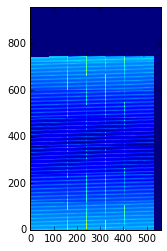

In [129]:
# Fenetre du tube
Xc=273.2;
Yc=438;
R=12;
dist=sqrt((X0-Xc)**2+(Y0-Yc)**2)
mask1,mask2=dis.uncorrect(dist)
print(shape(mask1))
print(shape(mask2))
#mask=logical_or(mask,mask2)
det.mask=mask
dis = Distortion(det,resize=True)

# affichage du beamstop pour trouver son centre
dummy=10**2
view=where(mask,dummy,glassy.data)
imshow((mask1), interpolation="nearest", origin="lower")
#axis([100, 400, 400, 800])
#clim([4.5, 5.1])

En fait le module uncorrect ne semble pas du tout faire l'inverse du module correct, donc mon plan ne fonctionne pas (cf. ci dessous), donc je fais tout en mode non corrigé.

/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


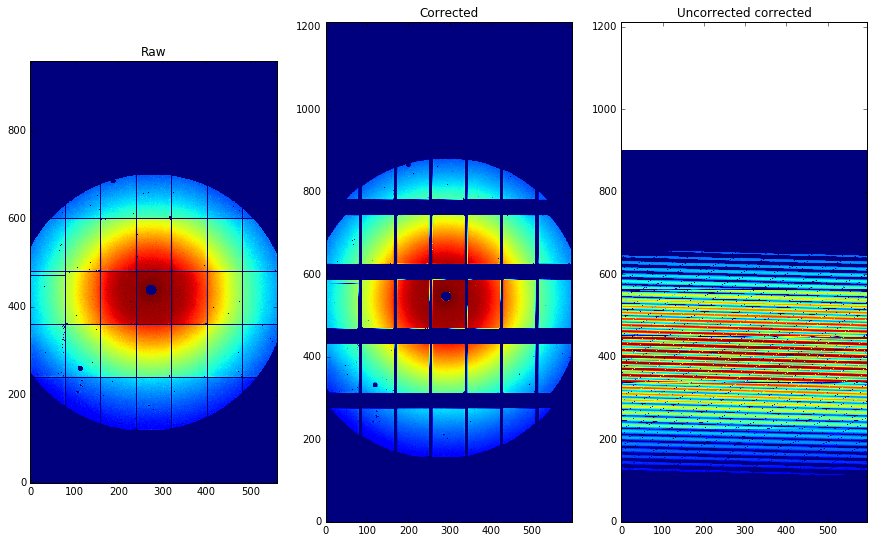

In [130]:
dummy=10**0
figure(figsize=(15,15))
subplot(1,3,1)
view=where(mask,dummy,glassy.data)
imshow(log10(view), interpolation="nearest", origin="lower")
clim([3, 5])
title('Raw')
subplot(1,3,2)
view=dis.correct(where(mask,dummy,glassy.data),dummy=dummy)
imshow(log10(view), interpolation="nearest", origin="lower")
clim([3, 5])
title('Corrected')
subplot(1,3,3)
view=dis.uncorrect(dis.correct(where(mask,dummy,glassy.data),dummy=dummy))[0]
imshow(log10(view), interpolation="nearest", origin="lower")
clim([3, 5])
title('Uncorrected corrected')

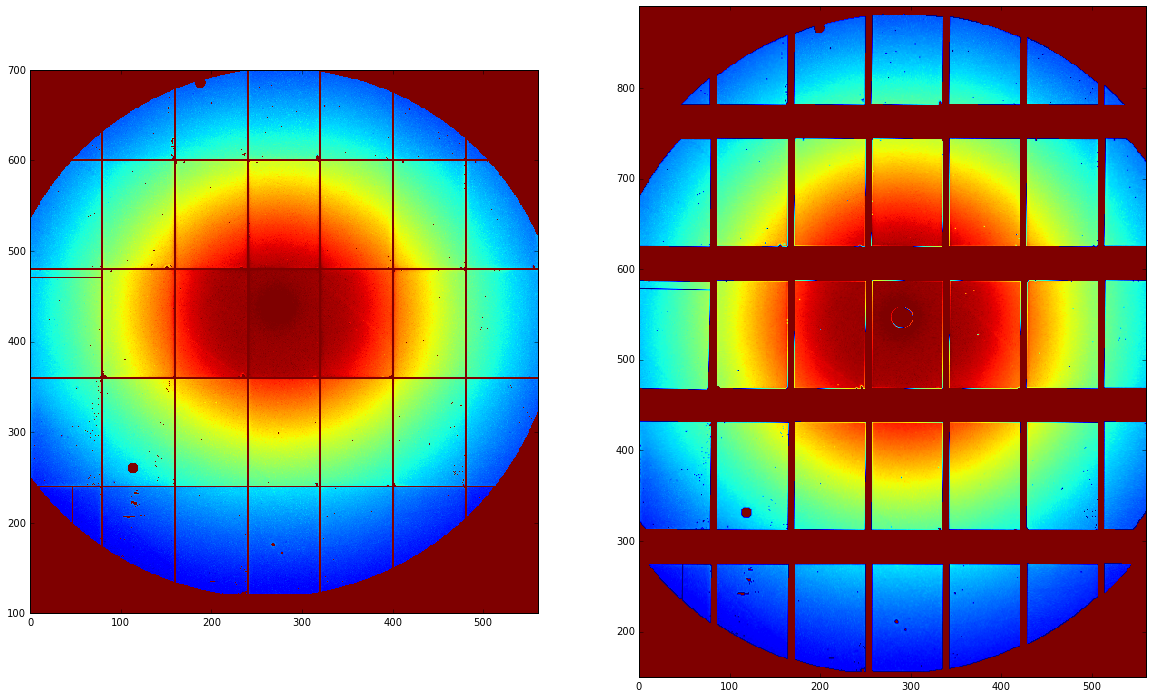

In [111]:

# fenetre du tube (une partie haute et une partie basse)
Xc=260;
Yc=438;
R=320;
dist=sqrt((X-Xc)**2+(Y-Yc)**2)
mask=logical_or(mask,dist>R)
Xc=275;
Yc=390;
R=310;
dist=sqrt((X-Xc)**2+(Y-Yc)**2)
mask=logical_or(mask,dist>R)
mask=logical_or(mask,Y<120)

# Trous d efficacite D7 (selon les cas peuvent être déjà masqués par le filtre médian)
Xc=113;
Yc=260;
R=6;
dist=sqrt((X-Xc)**2+(Y-Yc)**2)
mask=logical_or(mask,dist<R)
Xc=187.3;
Yc=685;
R=6;
dist=sqrt((X-Xc)**2+(Y-Yc)**2)
mask=logical_or(mask,dist<R)

det.mask=mask
dis = Distortion(det)

dummy=10**5
figure(figsize=(20,20))
subplot(1,2,1)
view=where(mask,dummy,glassy.data)
imshow(log10(view), interpolation="nearest", origin="lower")
axis([0, 560, 100, 700])
#axis([0, 100, 450, 600])
clim([3, 5])
subplot(1,2,2)
view=dis.correct(where(mask,dummy,glassy.data),dummy=dummy)
imshow(log10(view), interpolation="nearest", origin="lower")
axis([0, 560, 150, 890])
#axis([0, 100, 450, 600])
clim([3, 5])

Affichage de l'image du Glassy "brute" et "retransformée" pour corriger la géométrie. Les espèces de liserés en bord de modules ou de zones masquées sont normaux, c'est la trace de pixels non-entiers.

J'enregistre le masque en un edf.

In [93]:
# enregistrement du fichier
fabio.edfimage.edfimage(data=mask.astype("int8")).write(maskName)

## Calibration de la géométrie, création du poni

Je l'ai toujours fait en un shell en utilisant les scripts compilés de pyFAI, et en créant un fichier .sh du genre:

In [ ]:
# %load ../runCalib_four_25keV.sh

# a lancer via "sh runCalib_four_25keV.sh"

# le behenate d'argent
THEDATA="../raw/four/15Dec03D7_0505.edf"
THEWAVELENGTH="-w 0.509175330267"
#THEWAVELENGTH="-e 24.35"
THECALIBRANT="-c AgBh"
THEDETECTOR="-D d7_flat.h5"
THEDISTANCE="-l 1280"
THEMASK="-m mask_four.edf"
THERINGS="-r 7"
THECENTRE="--poni1=0.06848257 --poni2=0.03787192"
#OTHER="--no-tilt"
OTHER=" "

#pyFAI-calib ${THEDATA} ${THEWAVELENGTH} ${THEDETECTOR} ${THECALIBRANT} ${OTHER}

pyFAI-recalib ${THEWAVELENGTH} ${THECALIBRANT} ${THEDISTANCE} ${THEDETECTOR} ${THEMASK} ${THERINGS} ${THECENTRE} ${OTHER} ${THEDATA}


En principe, on doit pouvoir tout faire à l'intérieur du script python. Pour l'instant je ne capte vraiment pas comment faire...

Avant de lancer le fichier sh plus haut, il faut l'adapter à la manip :
* nom de l'image du behenate d'argent
* longueur d'onde
* détecteur
* estimation de la distance (en mm)
* nom du masque
* nombre d'anneaux à prendre en compte (c'est le"-r")
* les poni1 et poni2 sont une estimation de la position du centre, en metre.

Pour s'aider, on peut afficher le behenate d'argent en coordonnées corrigées en (m)


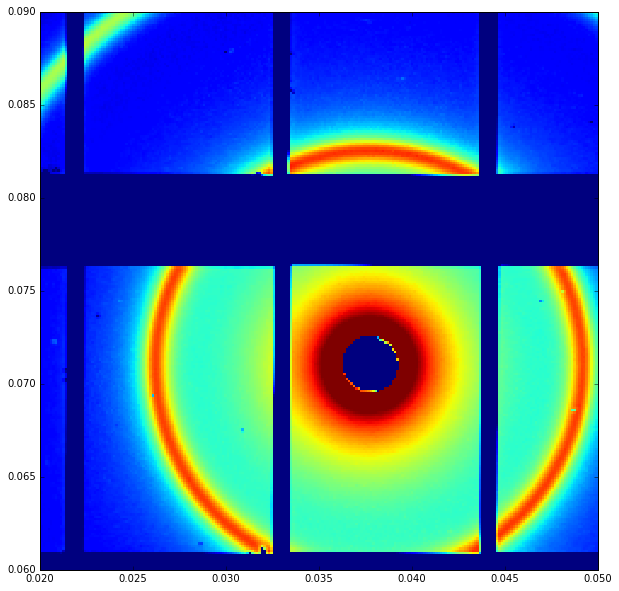

In [122]:
dummy=10**0
figure(figsize=(10,10))
view=dis.correct(where(mask,dummy,AgBh.data),dummy=dummy)
Xmax=dis.shape_in[0]*det.pixel1
Ymax=dis.shape_in[1]*det.pixel2
imshow(log10(view), interpolation="nearest", origin="lower", extent=[0,Ymax,0,Xmax],aspect='equal')
axis([0.02, 0.05,0.06, 0.09])
clim([2.5, 5.5])

On voit que le centre est bien vers 0.07 et 0.037 (dans le fichier sh ca doit etre un guess, pas forcément exact) et que poni1 est la coordonnées en z ou y (en vertical, quoi).

Supponsons que tout ait bien marché, on se retrouve avec un fichier poni qui reste à charger.

In [126]:
ai=pyFAI.load(pathExp+"raw/four/15Dec03D7_0505.poni")
# comme j'ai modifié le détecteur, notamment son masque, bam, je le charge ici
ai.detector=det
print(ai.detector)

Xpad S540 flat detector from NeXus file: d7_flat.h5	 PixelSize= 1.300e-04, 1.300e-04 m
Xpad S540 flat detector from NeXus file: ../d7_flat.h5	 PixelSize= 1.300e-04, 1.300e-04 m


## Définition des scripts d'intégration normalisation
Je commence par définir un script qui corrige les moniteurs de leur temps mort **s'il s'agit de PM** (pas de diode, par ex, à voir à chaque manip).

In [161]:
DEADTIME=0.0000018 # temps mort des pm en seconde
def corrPM(pm,sec) :
    # sec est le temps de comptage, c'est (pratiquement) toujours le premier compteur
    deadTime=DEADTIME/sec
    pm=-1.0/deadTime*log(1.0-pm*deadTime)
    return pm

Je définis aussi un script qui extrait du header d'une image un compteur ou un moteur. C'est pour quand il s'agit d'un tableau de valeurs, comme les moteurs ou les compteurs. Si on veut un paramètre qui est seul dans le header (style Epoch, wavelength, ou autre), il suffit de l'extraire en faisant Epoch=image.header['Epoch'], par exemple.

In [158]:
def readHeader(header,dictName,pos) :
    return fromstring(header[dictName],dtype=float,count=-1,sep=' ')[pos]

Définition assez générale d'une fonction norm prenant en argument une image, son image avec kapton (pour la transmission, peut etre identique à l'image), le bruit de fond sans et avec kapton (pour la transmission, peuvent être identiques).

In [266]:
# Re2= rayon classique de l'électron au carré
Re2=7.94e-10

def norm(imageName,imageTransName,bdfName,bdfTransName,ai,att_ep=1,K=1,flat=None,saveFile=True) :
    
    # angle solide (valeur statique Px*Py/L**2, la correction relative liée à l'angle est faite dans l'intégration)
    domega=ai.pixel1*ai.pixel2 / ai.dist
    
    # Nombre de points d'integration
    nbPts=1000
    # Range d'integration
    # radial_range=(0.01,1)
    radial_range=None
    
    # construction du nom de fichier
    base=os.path.splitext(os.path.splitext(imageName)[0])[0]
    filenametxt=base+".txt"
    
    # Lecture de l'image et du bruit de fond
    image=fabio.open(imageName)
    bdf=fabio.open(bdfName)
    
    # Lecture des header des images et bruit de fond avec kapton
    imageTransHeader=fabio.open(imageTransName).header
    bdfTransHeader=fabio.open(bdfTransName).header
    
    # Si on veut extraire du header des moteurs ou des compteurs ou autres, prendre plutot ceux de l'image que de imageTrans    
    xsamp=readHeader(image.header,'motor_pos',0)
    zsamp=readHeader(image.header,'motor_pos',1)
    Epoch=image.header['Epoch']
    
    # Extraction des compteurs du vide pour la transmission (attention à prendre la bonne colonne)
    pm0=corrPM(readHeader(bdfTransHeader,'counter_pos',1),readHeader(bdfTransHeader,'counter_pos',0))
    pm1=corrPM(readHeader(bdfTransHeader,'counter_pos',2),readHeader(bdfTransHeader,'counter_pos',0))
    
    # Définition du ratio pm1/pm0 à vide
    pm1_pm0_bdf=pm1/pm0
    
    # Lecture et integration du bdf
    mon_bdf=corrPM(readHeader(bdf.header,'counter_pos',1),readHeader(bdf.header,'counter_pos',0))
    q, I_bdf = ai.integrate1d(bdf.data,nbPts,unit="q_A^-1",radial_range=radial_range,flat=flat) 
    Res2 = ai.integrate1d(bdf.data**2,nbPts,unit="q_A^-1",radial_range=radial_range,flat=flat,all=True) 
    dI_bdf = sqrt((Res2['I']-I_bdf**2)/Res2['count'])/mon_bdf
    I_bdf = I_bdf/mon_bdf
    
    
    # Lecture et integration de l'image
    mon=corrPM(readHeader(image.header,'counter_pos',1),readHeader(image.header,'counter_pos',0))
    q, I = ai.integrate1d(image.data,nbPts,unit="q_A^-1",radial_range=radial_range,flat=flat) 
    Res2 = ai.integrate1d(image.data**2,nbPts,unit="q_A^-1",radial_range=radial_range,flat=flat,all=True) 
    dI = sqrt((Res2['I']-I**2)/Res2['count'])/mon
    I = I/mon
    n=Res2['count']
    
    # Calcul de la transmission (attention à prendre la bonne colonne)
    pm0=corrPM(readHeader(imageTransHeader,'counter_pos',1),readHeader(imageTransHeader,'counter_pos',0))
    pm1=corrPM(readHeader(imageTransHeader,'counter_pos',2),readHeader(imageTransHeader,'counter_pos',0))
    Tr=pm1/pm0/pm1_pm0_bdf
    if att_ep>0 :
        ep=-att_ep*log(Tr)
    else :
        ep=-att_ep # si att_ep est négatif, c'est qu'on a rentré direct l'épaisseur (en microns). Ex: att_ep=-1000 -> ep=1mm

    # pour la propa des incertitudes je garde leur valeur relative
    dI=dI/I
    ddI_bdf=dI_bdf/I_bdf

    # normalisation du signal
    I=I-Tr*I_bdf
    I=I/(ep*Tr*domega*1e4*Re2*K) # le 1e4 fait passer l'epaisseur de microns a angstroms

    # propagation des incertitudes
    dI=dI*I+ddI_bdf*I_bdf*Tr
    #print filenametxt
    
    if saveFile :
        savetxt(filenametxt,np.column_stack((q,I,dI,n)))
    
    return q, I, dI, n, base, Tr, ep, Epoch, xsamp, zsamp
    
def read_txt(filename) :
    A=loadtxt(filename)
    return A[:,0], A[:,1], A[:,2], A[:,3]

## Calibration absolue et création du flat
Je lance la normalisation sur le glassy avec un facteur de normalisation égal à 1 (paramètre K).

In [267]:
q, I, dI, n, base, Tr, ep, Epoch, xsamp, zsamp = norm(glassyName,glassyName,bdfName,bdfName,ai,att_ep=-1000,K=1,flat=None,saveFile=False)

/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in true_divide
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt


Je fitte le glassy expérimental par le glassy théorique:

Number of photons per counts in the pm0: 467070.686299


/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


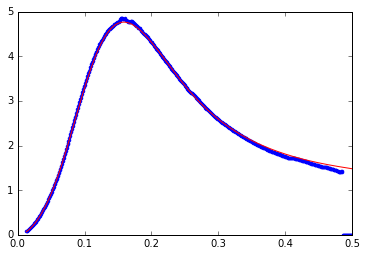

In [268]:
def func(q, p1):
  return p1*glassyTheo(q)

c = (n > 2) & (dI > 0)
popt, pcov = curve_fit(func, q[c], I[c], p0=1.0e6)
plot(q,I/popt*q**2,'.',q,glassyTheo(q)*q**2,'-r')
xlim([0, 0.5])
K=popt[0]
print("Number of photons per counts in the pm0: %s"%K)

On va maintenant créer un flat. Pour cela, on prend le glassy auquel on soustrait le bruit de fond.

/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in true_divide
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in sqrt


(0, 0.5)

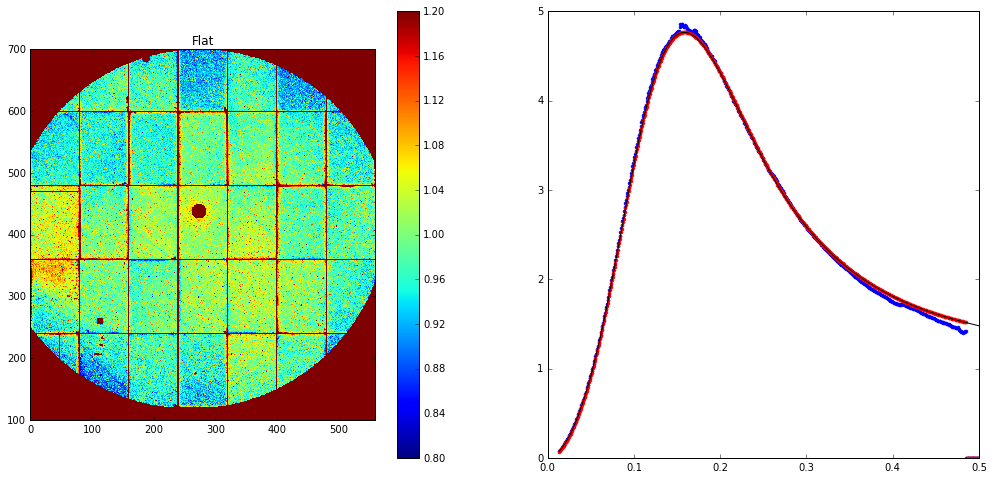

In [274]:
mon=corrPM(readHeader(glassy.header,'counter_pos',1),readHeader(glassy.header,'counter_pos',0))
mon_bdf=corrPM(readHeader(bdf.header,'counter_pos',1),readHeader(glassy.header,'counter_pos',0))
domega=ai.pixel1*ai.pixel2 / ai.dist
flat=((glassy.data/mon-Tr*bdf.data/mon_bdf)/(ep*Tr*domega*1e4*Re2*K)) / glassyTheo(ai.qArray()/10)

q, I, dI, n, base, Tr, ep, Epoch, xsamp, zsamp = norm(glassyName,glassyName,bdfName,bdfName,ai,att_ep=-1000,K=K,flat=None,saveFile=False)
det.flat=flat
ai.det=det
q, I2, dI2, n2, base, Tr, ep, Epoch, xsamp, zsamp = norm(glassyName,glassyName,bdfName,bdfName,ai,att_ep=-1000,K=K,flat=flat,saveFile=False)

figure(figsize=(17,8))
subplot(1,2,1)
imshow(where(ai.mask,2,flat),interpolation='none',origin='lower',clim=[0.8,1.2])
axis([0,559,100,700])
title('Flat')
colorbar()
subplot(1,2,2)
plot(q,I*q**2,'.b',q,I2*q**2,'.r',q,glassyTheo(q)*q**2,'-k')
xlim([0, 0.5])


Et on est près pour lancer la normalisation sur tous les fichiers obtenus dans cette config...

On peut le faire en lançant des scripts sur ce mode là (attention celui ci ne marchera pas, c'est un ex):